In [1]:
import torch
import torchvision
from torchvision.datasets import FashionMNIST

In [2]:
dataset = FashionMNIST(root = 'fashion/', download= True)

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
len(dataset)

60000

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

Ankle boot


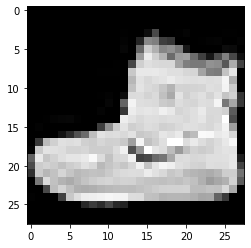

In [5]:
dress, label = dataset[0]
plt.imshow(dress, cmap='gray')
print(dataset.classes[label])

In [6]:
import torchvision.transforms as transforms

In [7]:
dataset = FashionMNIST(root='fashion/', train = True, transform= transforms.ToTensor())

test_dataset = FashionMNIST(root = 'fashion/', train = False, transform= transforms.ToTensor())

In [8]:
img_tensor, label = dataset[0]

print(img_tensor.shape, dataset.classes[label])

torch.Size([1, 28, 28]) Ankle boot


In [9]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [50000,10000])
len(train_ds), len(valid_ds)

(50000, 10000)

In [10]:
from torch.utils.data import DataLoader

batch_size = 100

train_dl = DataLoader(train_ds, batch_size, shuffle= True)
valid_dl = DataLoader(valid_ds, batch_size)

In [11]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

In [12]:
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [13]:
class fashionModel(nn.Module):
    def __init__(self,input_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        xb = xb.view(xb.size(0),-1)
        
        out = self.linear1(xb)
        
        out = nn.functional.relu(out)
        
        out = self.linear2(out)
        
        return out
    
    def loss_detection(self, batch):
        images, labels = batch
        out = self(images)
        loss = nn.functional.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        
        out = self(images)
        loss = nn.functional.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        
        return {'val_loss': epoch_loss, 'val_acc': epoch_acc}
    
    def epoch_end(self, epoch, result):
        print('Epoch [{}], val_loss:{:.4f}, val_acc: {:.2f}'.format(epoch+1, result['val_loss'], result['val_acc']))
    

In [14]:
input_size = 784
hidden_size = 32
num_classes = 10

In [15]:
model = fashionModel(input_size, hidden_size, num_classes)

In [16]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [17]:
def evaluate(model, val_dl):
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, valid_dl, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_dl:
            loss = model.loss_detection(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, valid_dl)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
model = fashionModel(input_size, hidden_size, num_classes)

In [18]:
history1 = fit(10,0.01, model, train_dl, valid_dl)

Epoch [1], val_loss:0.9785, val_acc: 0.68
Epoch [2], val_loss:0.7589, val_acc: 0.74
Epoch [3], val_loss:0.6685, val_acc: 0.77
Epoch [4], val_loss:0.6129, val_acc: 0.79
Epoch [5], val_loss:0.5744, val_acc: 0.80
Epoch [6], val_loss:0.5489, val_acc: 0.81
Epoch [7], val_loss:0.5278, val_acc: 0.82
Epoch [8], val_loss:0.5134, val_acc: 0.83
Epoch [9], val_loss:0.4984, val_acc: 0.83
Epoch [10], val_loss:0.4879, val_acc: 0.83


In [19]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    
    _,preds = torch.max(yb, dim = 1)
    return preds[0].item()

label: Trouser and Prediction: Trouser


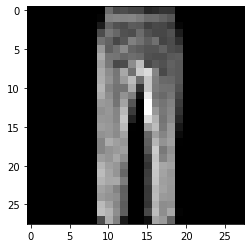

In [33]:
img, label = test_dataset[1118]
plt.imshow(img[0], cmap = 'gray')

print('label: {} and Prediction: {}' .format(dataset.classes[label],dataset.classes[predict_image(img, model)]))